### SIIM ML Education Sub-Committee
Tutorial Notebook Series

Tutorial Authors:\
Timothy Kline, PhD\
Darryl Wright, PhD

# Segmenting kidneys in MRI images

In this tutorial we will explore implementing an automated segmentation method. The challenge is to create a method for performing segmentation of kidneys in MRI images of mice.  The data set consists of 150 axial MRI images from a variety of mouse models.  The kidneys were manually segmented and you will use these manual segmentations to develop your own deep learning model. You can read more about this data set in [Edwards et al. (2021)](https://pubmed.ncbi.nlm.nih.gov/32828755/).

The goals of this tutorial are:

  1. To train a deep learning model and learn the basics of keras
  
  2. To learn to interpret the results of training and validation
  
  3. To identify beneficial avenues for improving peformance.
  
  

## Note: tasks for you to complete are indicated with a TODO. 

# Prerequisites


### TODO: Set up your environment
```pip install numpy nibabel tensorflow keras matplotlib scikit-image keras-unet scikit-learn```

Once complete the cell below should run without error.

Note: you can pip install directly in your jupyter notebook. Just add an exclamation point at the beginning (this allows you to execute Terminal commands within a jupyter notebook).

Example: 

```
!pip install keras-unet
```

In [1]:
# Install missing components for colab
!pip install keras_unet

In [2]:
# Libraries
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### Clone repo

In [3]:
!git clone 'https://github.com/TLKline/AutoTKV_MouseMRI/' 

'git' is not recognized as an internal or external command,
operable program or batch file.


# Data preparation and familiarization

## Read in the data set

We are now in a position to read in the data.  We will start by reading in the names of the files and corresponding segmentations.  We will also create an array called ```indices``` that we will use to index into the ```images``` and ```segmentations``` arrays in the next step. 

In [9]:
data_path = 'AutoTKV_MouseMRI/AllTrainingImages/'
images = []
segmentations = []
for f in os.listdir(data_path):
  if 'label' in f:
    continue
  else:
    images.append(f)
    segmentations.append(f.replace('.nii', '-label.nii'))

print(images[0], segmentations[0])
images = np.array(images)
segmentations = np.array(segmentations)

indices = np.array(range(len(images))) # we will use this in the next step.

7_F1_m_WT_tk09_12wk_Ln1_Exp006_Pro001avw.nii.gz 7_F1_m_WT_tk09_12wk_Ln1_Exp006_Pro001avw-label.nii.gz


## Train-validation-test split

### TODO: use ```sklearn.model_selection.train_test_split``` to split the data into training and test partitions.

The next step is to define the training, validation and test sets.  Use ```sklearn.model_selection.train_test_split``` and the ```indices``` array to create two new arrays with indices corresponding to a training partition with 75% of the data set and a test partition with 25% of the data.

In [10]:
train, test = train_test_split(indices, test_size=0.25) # TODO: split indices into training and test partitions

### TODO: use ```sklearn.model_selection.train_test_split``` to split a validation set from the training partition.
​

Define a training and validation split. Use ```sklearn.model_selection.train_test_split``` and the ```train``` array to create two new arrays with indices corresponding to a training partition with 75% of the data set and a validation parition with 25% of the data.

In [11]:
train, valid = train_test_split(train, test_size=0.25) # TODO: split train into training and validation partitions

Let's see how these ```train```, ```valid``` and ```test``` arrays look.

In [12]:
print(train)
print(valid)
print(test)

[67 31 65 41 50 63 17 77  7 84 12 32 11 21 72 30 38 20 10 44 39 64  3  4
 69 81 75 37 47 87 13 28 91 59 74 54 62 15 90 83 25 58 29  9  2 86 23 78
 60 27 22]
[26 18  5 14 46 36 24 66 52  1 85 68 70 48  0 57 35 43]
[42 51 71 33 73  8 82 76 16 34 55 53 19 89  6 79 56 49 88 40 61 80 45]


Let's double check that there is no overlap in the partitions.

In [13]:
assert list(np.intersect1d(train, valid)) == []
assert list(np.intersect1d(train, test)) == []
assert list(np.intersect1d(valid, test)) == []

Below are is a helper function that demonstrates how to read a .nii.gz file with [nibabel](https://nipy.org/nibabel/).

In [14]:
def read_nifti_file(path):
  nib_object = nib.load(path)
  nib_data = nib_object.get_fdata()
  return nib_data

We will use this function to help familiarise ourselves with the format of the data.

## TODO: read in an example image and the corresponding segmentation.

Use the above function to read in the first image and segmentation from the training partition and inspect that shape of the returned matrix.

In [15]:
example_image = read_nifti_file(data_path+images[train][0]) # TODO: read in the first image from the training partition
example_segmentation = read_nifti_file(data_path+segmentations[train][0])  # TODO: read in the first segmentation from the training partition

print(example_image.shape, example_segmentation.shape)

(256, 256, 16) (256, 256, 16)


## TODO : visualise the first slice from both the image and segmentation

(-0.5, 255.5, 255.5, -0.5)

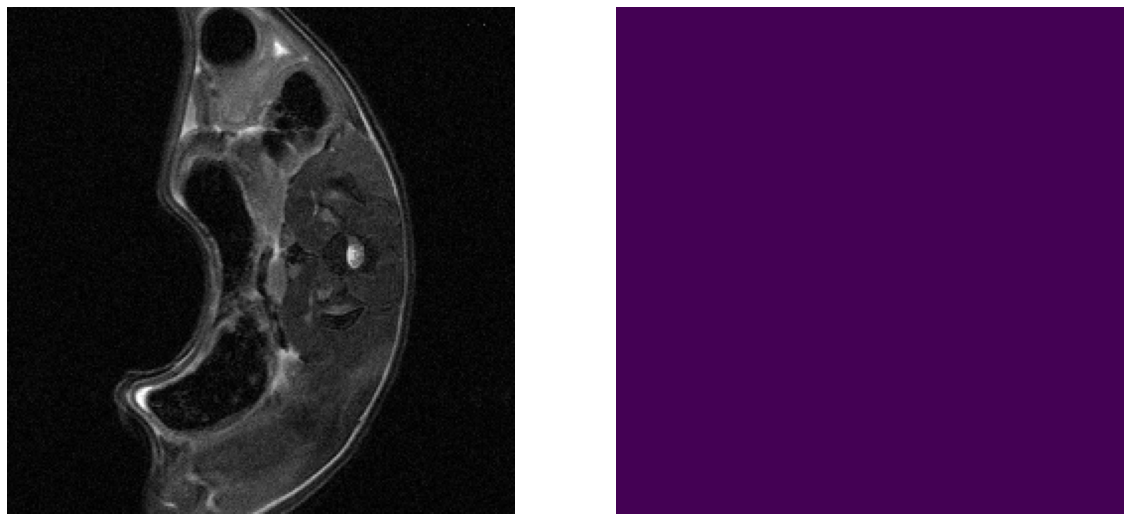

In [16]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(example_image[:,:,0], cmap='gray') # TODO: display the first slice from the image
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(example_segmentation[:,:,0])  # TODO: display the first slice from the segmentation
ax2.axis('off')

## TODO : visualise the tenth slice from both the image and segmentation

(-0.5, 255.5, 255.5, -0.5)

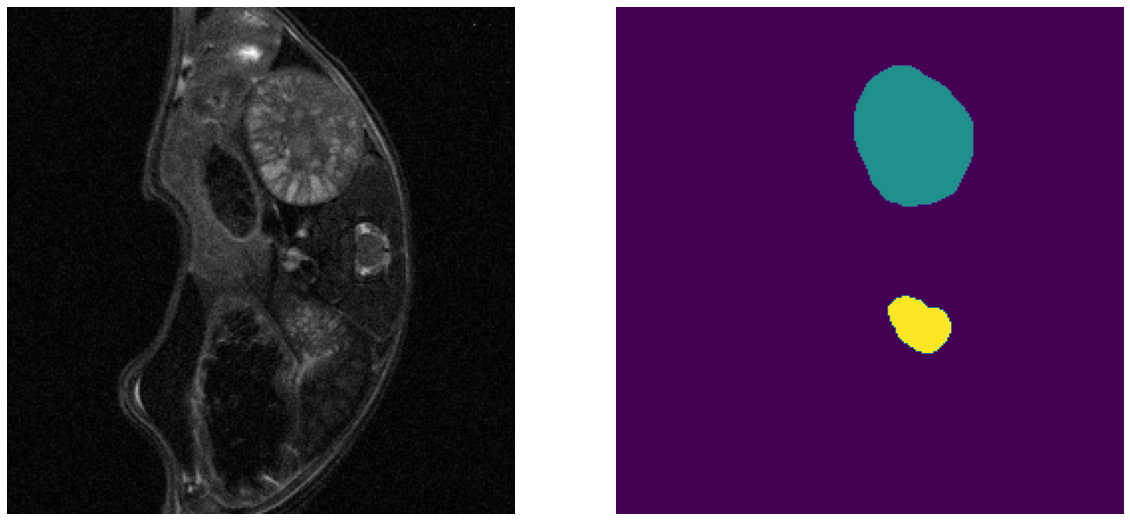

In [17]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(example_image[:,:,10], cmap='gray') # TODO: display the tenth slice from the image
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(example_segmentation[:,:,10])  # TODO: display the tenth slice from the segmentation
ax2.axis('off')

# Image Preprocessing

Below is a second helper function that relies on ```read_nifti_file``` to read the images and segmentation files to create the data matrices we require when working with neural networks.  This function also implements resizing of the image slices to a default of 64-by-64 pixels.

## TODO: In the cell below give two reasons why we resize the images.

  1. To ensure all image slices are the same size to feed to the U-Net.
  
  2. To reduce the dimensionality of the data for faster training.

... #TODO: give two reasons for resizing the images in this data set.

In [18]:
def retrieve_images_and_segmentations(data_path, images, segmentations, size=(64,64)):
  x = []
  y = []
  for i in range(len(images)):
    seg = read_nifti_file(data_path+segmentations[i])
    img = read_nifti_file(data_path+images[i])
    assert img.shape == seg.shape
    seg = resize(seg,(size[0], size[1], seg.shape[-1]))
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(seg.shape[-1]):
      # ignore slices that don't have a segmentation
      if np.sum(seg[:,:,j]) == 0:
        continue
      x.append(img[:,:,j])
      y.append(seg[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]
  y = np.array(y)[:,:,:,np.newaxis]

  # randomly shuffle slices
  m = x.shape[0]
  order = np.random.permutation(m)

  return x[order], y[order]

The function above also ignores image slices with no corresponding segmentation and treats each slice as an independent training example.  This "bakes in" two assumptions:

  1. that slices with no segmentation provide no useful information for training
  
  2. that the information in one slice has no dependence on the preceeding or subsequent images in the image volume.
  
Think about the implications of these assumptions and why we chose them here.  Which of these assumptions might have the greatest impact on the performance we might be able to achieve?

## TODO: get the data matrices for each of the partitions.

Use ```retrieve_images_and_segmentations``` to retrieve the image and segmentation matrices we need to develop and test our model.  Use the ``train```, ```valid``` and ```test``` arrays we defined above.

In [19]:
x_train, y_train = retrieve_images_and_segmentations(data_path, images[train], segmentations[train]) #TODO: get the matrices for the training partition
print(x_train.shape, y_train.shape)

(689, 64, 64, 1) (689, 64, 64, 1)


In [20]:
x_valid, y_valid = retrieve_images_and_segmentations(data_path, images[valid], segmentations[valid]) #TODO: get the matrices for the validation partition
print(x_valid.shape, y_valid.shape)

(232, 64, 64, 1) (232, 64, 64, 1)


In [21]:
x_test, y_test = retrieve_images_and_segmentations(data_path, images[test], segmentations[test]) #TODO: get the matrices for the test partition
print(x_test.shape, y_test.shape)

(326, 64, 64, 1) (326, 64, 64, 1)


## Visualize the training data

Let's perform a sanity check to ensure that the data matrices we have just created look correct before we try training a model.

It is common to visualise the segmentations as contours overlaid on the image.  To do this we use ```skimage.measure.find_contours``` to find contours in the segmentation masks.  We will also modify this function later to visualize the results of the model we train.

In [53]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

Here we visluaize the first 4 images from the training partition.

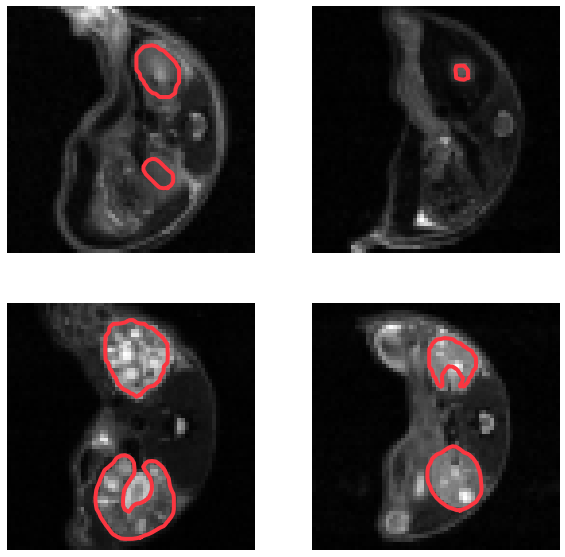

In [54]:
visualise_data(x_train, y_train)

# Training the model

We are now ready to train a model to segment the kidneys.

To do this we will use a [U-Net](https://arxiv.org/pdf/1505.04597.pdf) architecture.  We are also going to use the [Keras](https://keras.io/) Python deep learning API to build and train a model.  There are great starter guides to Keras [here](https://keras.io/getting_started/), lots of code examples [here](https://keras.io/examples/) and even an example of how to build a U-Net-like architecture from scratch in Keras [here](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

In this notebook, we are going to focus on the very high level API and take advantage of the [karolzak/keras-unet github repository](https://github.com/karolzak/keras-unet) that implements a number of U-Net type architectures which you install in the first TODO for this notebook.

The high level API requires three steps:

  1. instantiate a [Model](https://keras.io/api/models/model/#model-class) object.
  
  2. compile the model
  
  3. fit the model to the data
  
In general, the Model object exposes methods similar to the sklearn API such as ```.fit``` and ```.predict``` along with other neural network specific methods.


### TODO: instantiate a custom_unet object using the correct input_shape

To start we will instantiate a [custom_unet](https://github.com/karolzak/keras-unet/blob/master/keras_unet/models/custom_unet.py) object from the [karolzak/keras-unet repository](https://github.com/karolzak/keras-unet).  Use the correct ```input_shape``` given our data set and leave all other parameters as defaults.

### TODO:  compile the model use the ```jaccard_distance``` as the loss, ```dice_coef``` as a metric to track and use the ```tf.keras.optimizers.Adam``` optimizer with a learning rate of 3e-4.

### TODO: fit the model to the training set and use the ```validation_data``` parameters of the fit method to track the performance on the validation set.  Train the  model for 5 epochs.  Assign the result of fit to the ```history``` variable.

In [26]:
model = custom_unet(input_shape=(64, 64, 1)) #TODO: instantiate the custom_unet object

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])

history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=10)

Epoch 1/10
22/22 [==============================] - 34s 1s/step - loss: 0.4397 - dice_coef: 0.2355 - val_loss: 0.7289 - val_dice_coef: 0.1906
Epoch 2/10
22/22 [==============================] - 32s 1s/step - loss: 0.3660 - dice_coef: 0.3112 - val_loss: 0.6179 - val_dice_coef: 0.2177
Epoch 3/10
22/22 [==============================] - 31s 1s/step - loss: 0.3201 - dice_coef: 0.3466 - val_loss: 0.6336 - val_dice_coef: 0.2141
Epoch 4/10
22/22 [==============================] - 31s 1s/step - loss: 0.2812 - dice_coef: 0.3789 - val_loss: 0.5455 - val_dice_coef: 0.2402
Epoch 5/10
22/22 [==============================] - 31s 1s/step - loss: 0.2468 - dice_coef: 0.4082 - val_loss: 0.4373 - val_dice_coef: 0.2829
Epoch 6/10
22/22 [==============================] - 31s 1s/step - loss: 0.2199 - dice_coef: 0.4386 - val_loss: 0.3206 - val_dice_coef: 0.3494
Epoch 7/10
22/22 [==============================] - 32s 1s/step - loss: 0.1986 - dice_coef: 0.4601 - val_loss: 0.2457 - val_dice_coef: 0.4114
Epoch 

# Evaluating model performance

Here we inspect the returned training history.  ```history.history``` tracks the loss and metrics for each epoch.

In [27]:
print(history.history)

{'loss': [0.4397260248661041, 0.36603018641471863, 0.32006070017814636, 0.28116029500961304, 0.24676872789859772, 0.21988371014595032, 0.1986498385667801, 0.18048536777496338, 0.1651258021593094, 0.15227580070495605], 'dice_coef': [0.2355063557624817, 0.31121131777763367, 0.3466453552246094, 0.37888428568840027, 0.40822169184684753, 0.43861380219459534, 0.46009713411331177, 0.4880122244358063, 0.5107598900794983, 0.5304946303367615], 'val_loss': [0.7288731932640076, 0.6178982853889465, 0.633595883846283, 0.5454518795013428, 0.43728744983673096, 0.3206073045730591, 0.24566377699375153, 0.22805938124656677, 0.13620956242084503, 0.09373927861452103], 'val_dice_coef': [0.19059909880161285, 0.21770279109477997, 0.21406996250152588, 0.24019035696983337, 0.28294461965560913, 0.3494220972061157, 0.41135427355766296, 0.42981821298599243, 0.5549589395523071, 0.6434729099273682]}


## Learning curves

### TODO: plot both the training and validation loss learning curves

Text(0.5, 0, 'Jaccard loss')

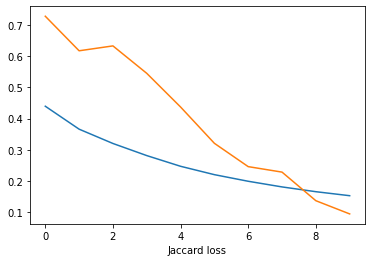

In [30]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

Text(0.5, 0, 'Dice coefficient')

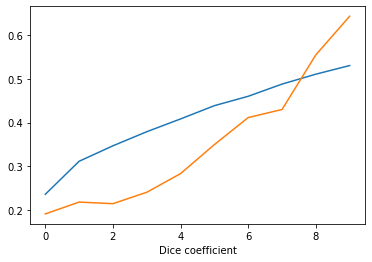

In [31]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

### TODO: in the cell below briefly describe what you can conclude from these learning curves.  What is the simplest change we could make to the training proceedure to help improve performance?

... #TODO: describe conclusions from learning curves, suggest a change to the training procedure.

Train the model for more epochs

## Evaluating segmentation performance

### TODO: use the trained model to predict on the training set.

In [32]:
y_pred_train = model.predict(x_train) #TODO: predict on the training set
y_pred_train = y_pred_train.astype('float') # casting to type float to avoid ValueError later

### TODO: calculate the Dice coefficient between the manual and predicted segmentations for the validation set

In [46]:
print('Dice:')
print(np.array(dice_coef(y_train, y_pred_train.astype('float'))))

Dice:
0.6634503833543086


### TODO: similarly calculate the Dice coefficient on the validation set

In [45]:
y_pred_valid = model.predict(x_valid) #TODO: predict on the validation set
y_pred_valid = y_pred_valid.astype('float') # casting to type float to avoid ValueError later
print('Dice:')
print(np.array(dice_coef(y_valid, y_pred_valid.astype('float'))))

Dice:
0.6472854323407218


What do you make of this comparison of Dice coefficients measured on the training and validation sets? Is this performance good enough? Let's gather more evidence by visualising some of the segmentations.

Below is a modification of the ```visualise_data()``` method we used above. This modified version allows to visualise both the groundtruth (manual) and predicted segmentations.  The groundtruth segmentation is shown in red and the predicted segmentaiton is shown in blue.

In [50]:
def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

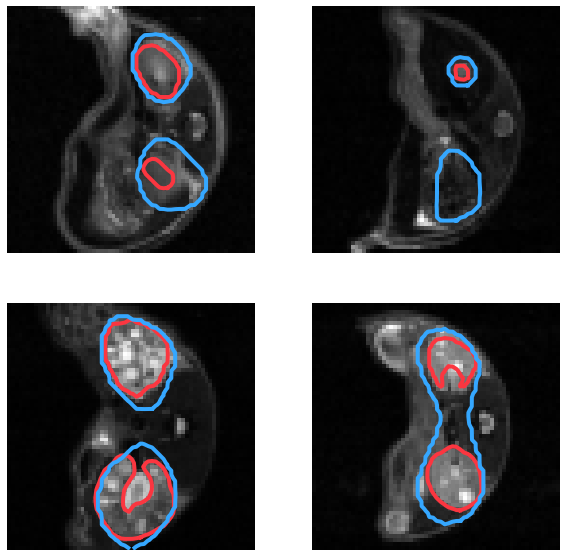

In [51]:
visualise_data_and_prediction(x_train, y_train, y_pred_train)

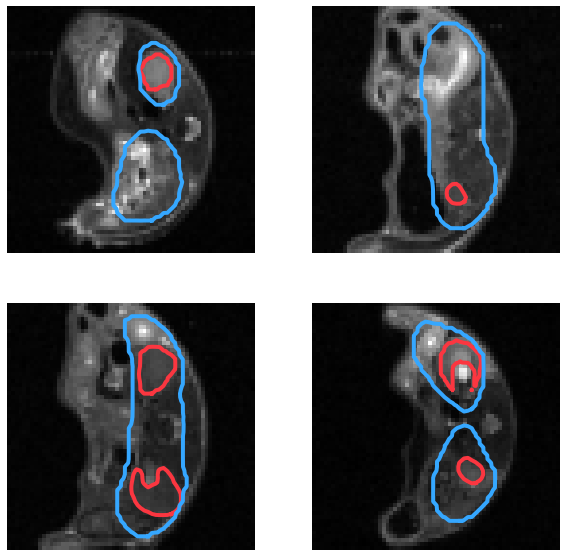

In [52]:
visualise_data_and_prediction(x_valid, y_valid, y_pred_valid)

### TODO: Given the evidence we have gathered do you think we are in the high bias or high variance regime? Provide your answer and justification in the cell below. 

... # TODO: high bias or high variance? Justify your answer.

High bias. Both the training and validation dice coefficients are low and similar.  Visually, the model is performing poorly on both the training and validation sets.

# Improving performance.

### TODO: Implement the change to the training procedure you identified earlier and replicate the above analysis.  Ensure the change you make runs in reasonable time (<20mins).  As guidance on a macbook pro training takes ~20 seconds per epoch this may be significantly different for you.

In [ ]:
model = custom_unet(input_shape=(64, 64, 1)) #TODO: instantiate the custom_unet object

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])

history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=50)

/Users/mri3977/PyEnv/marvin3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
21/21 [==============================] - 18s 793ms/step - loss: 0.4887 - dice_coef: 0.1681 - val_loss: 0.4656 - val_dice_coef: 0.1634
Epoch 2/50
21/21 [==============================] - 17s 801ms/step - loss: 0.4127 - dice_coef: 0.2644 - val_loss: 0.5761 - val_dice_coef: 0.2342
Epoch 3/50
21/21 [==============================] - 16s 779ms/step - loss: 0.3502 - dice_coef: 0.3202 - val_loss: 0.5644 - val_dice_coef: 0.2396
Epoch 4/50
21/21 [==============================] - 16s 745ms/step - loss: 0.3078 - dice_coef: 0.3533 - val_loss: 0.4912 - val_dice_coef: 0.2658
Epoch 5/50
21/21 [==============================] - 16s 740ms/step - loss: 0.2789 - dice_coef: 0.3759 - val_loss: 0.3613 - val_dice_coef: 0.3298
Epoch 6/50
21/21 [==============================] - 15s 727ms/step - loss: 0.2531 - dice_coef: 0.3997 - val_loss: 0.2766 - val_dice_coef: 0.3910
Epoch 7/50
21/21 [==============================] - 15s 722ms/step - loss: 0.2302 - dice_coef: 0.4232 - val_loss: 0.1743 - val_dic

Text(0.5, 0, 'Jaccard loss')

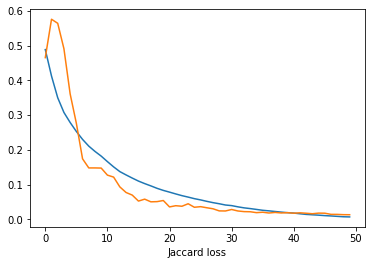

In [ ]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

Text(0.5, 0, 'Dice coefficient')

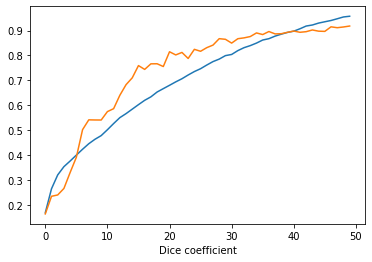

In [ ]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [ ]:
y_pred_train = model.predict(x_train) #TODO: predict on the training set
y_pred_train = y_pred_train.astype('float') # casting to type float to avoid ValueError later
dice_coef(y_train, y_pred_train.astype('float'))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9817301852393022>

In [ ]:
y_pred_valid = model.predict(x_valid) #TODO: predict on the validation set
y_pred_valid = y_pred_valid.astype('float') # casting to type float to avoid ValueError later
dice_coef(y_valid, y_pred_valid.astype('float'))

<tf.Tensor: shape=(), dtype=float64, numpy=0.921967051206709>

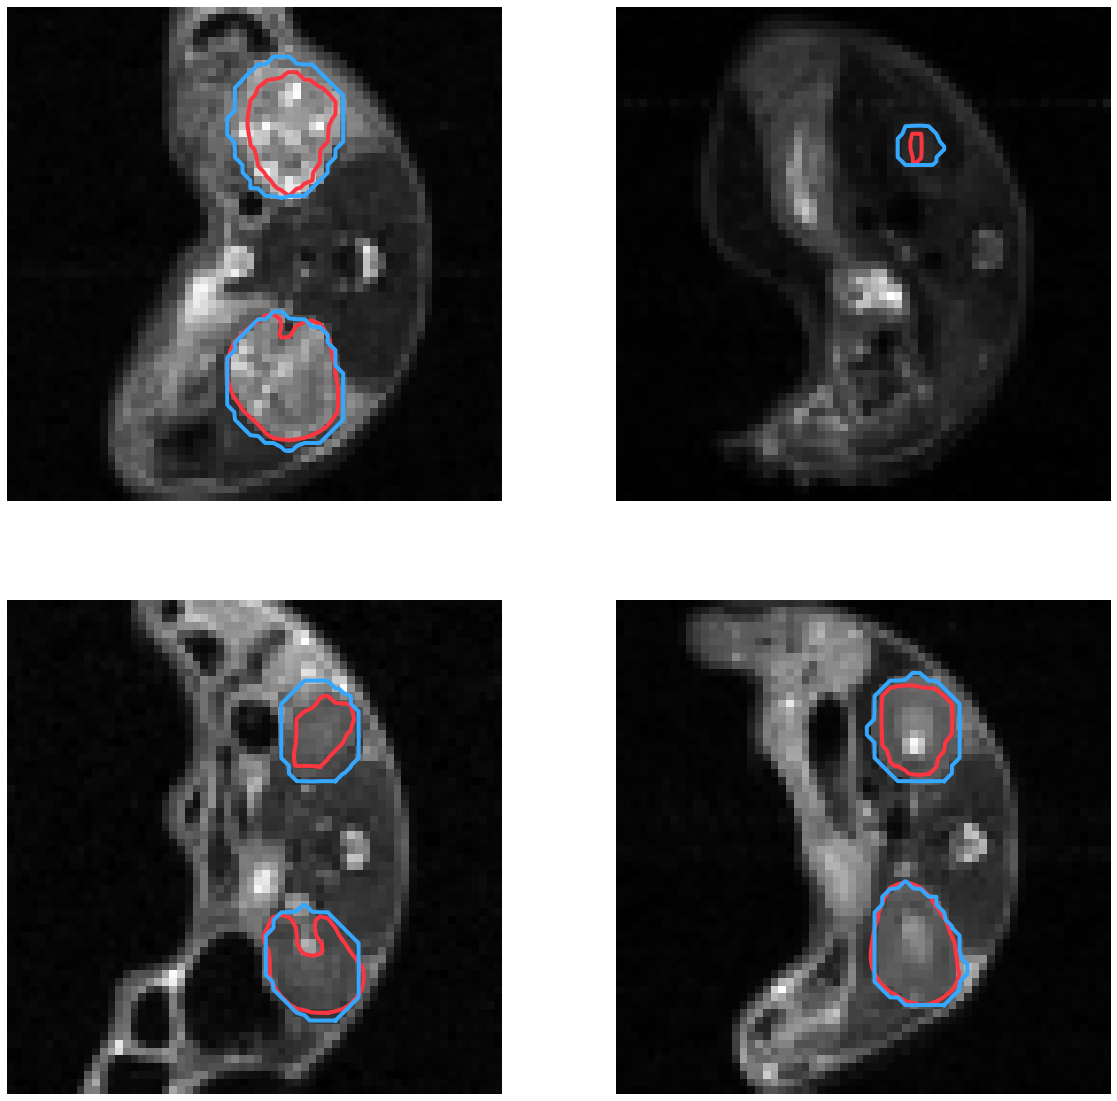

In [ ]:
visualise_data_and_prediction(x_train, y_train, y_pred_train)

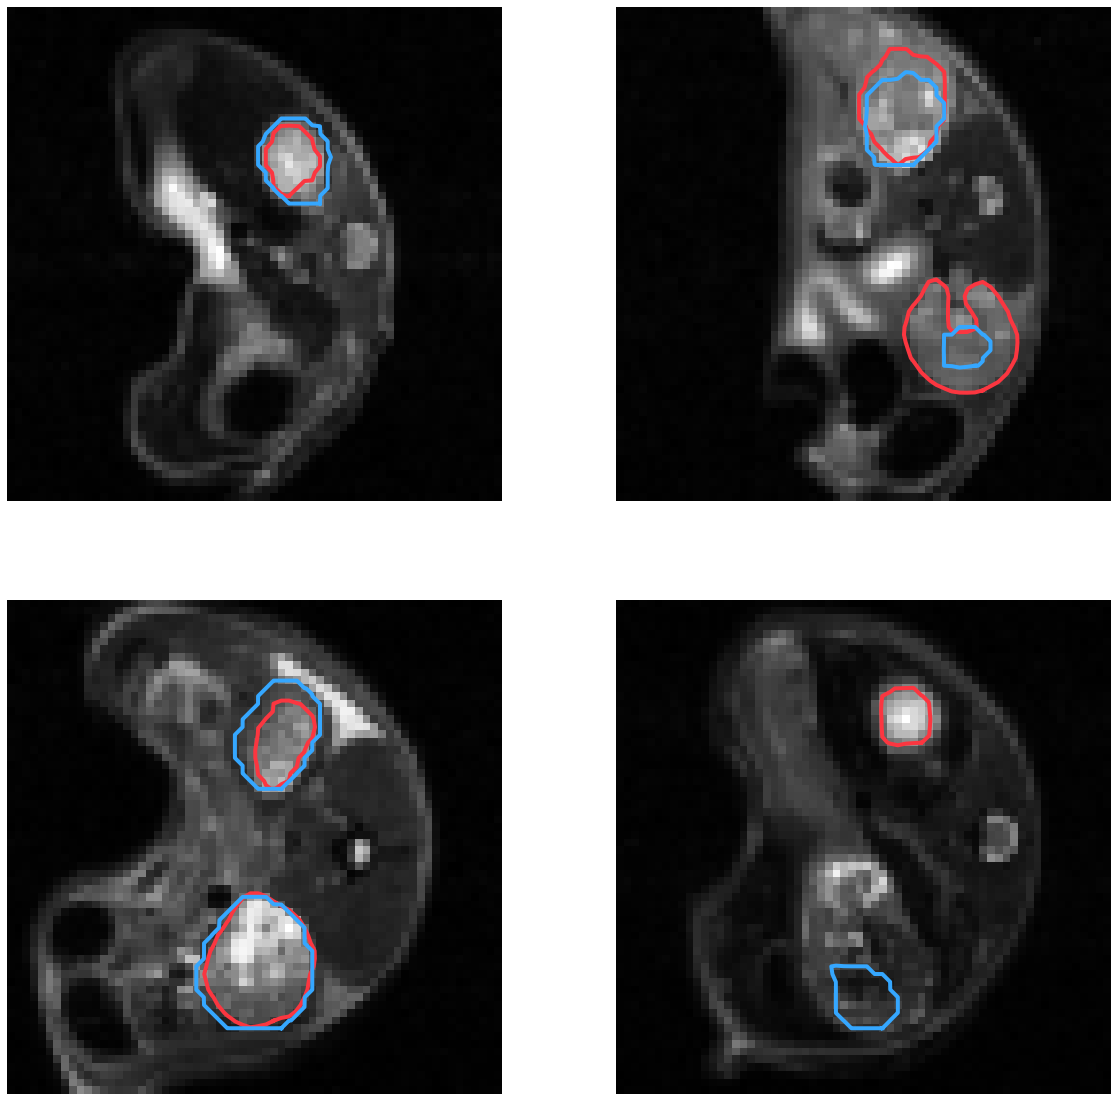

In [ ]:
visualise_data_and_prediction(x_valid, y_valid, y_pred_valid)

### TODO: Did the performance improve? What is the greatest source of error now, bias or variance?

... #TODO: Did performance improve? What's the greatest source of error.

Yes, the performance improved from ~0.35 to ~0.95.  Variance is the greatest source of error.  **But this will depend on how many additional epochs the model is trained for.**

### TODO: Use this model to predict on the test set.  Measure the Dice coefficient and visualize the results.

In [ ]:
y_pred_test = model.predict(x_test) #TODO: predict on the validation set
y_pred_test = y_pred_test.astype('float') # casting to type float to avoid ValueError later
dice_coef(y_test, y_pred_test.astype('float'))

<tf.Tensor: shape=(), dtype=float64, numpy=0.9530664207223566>

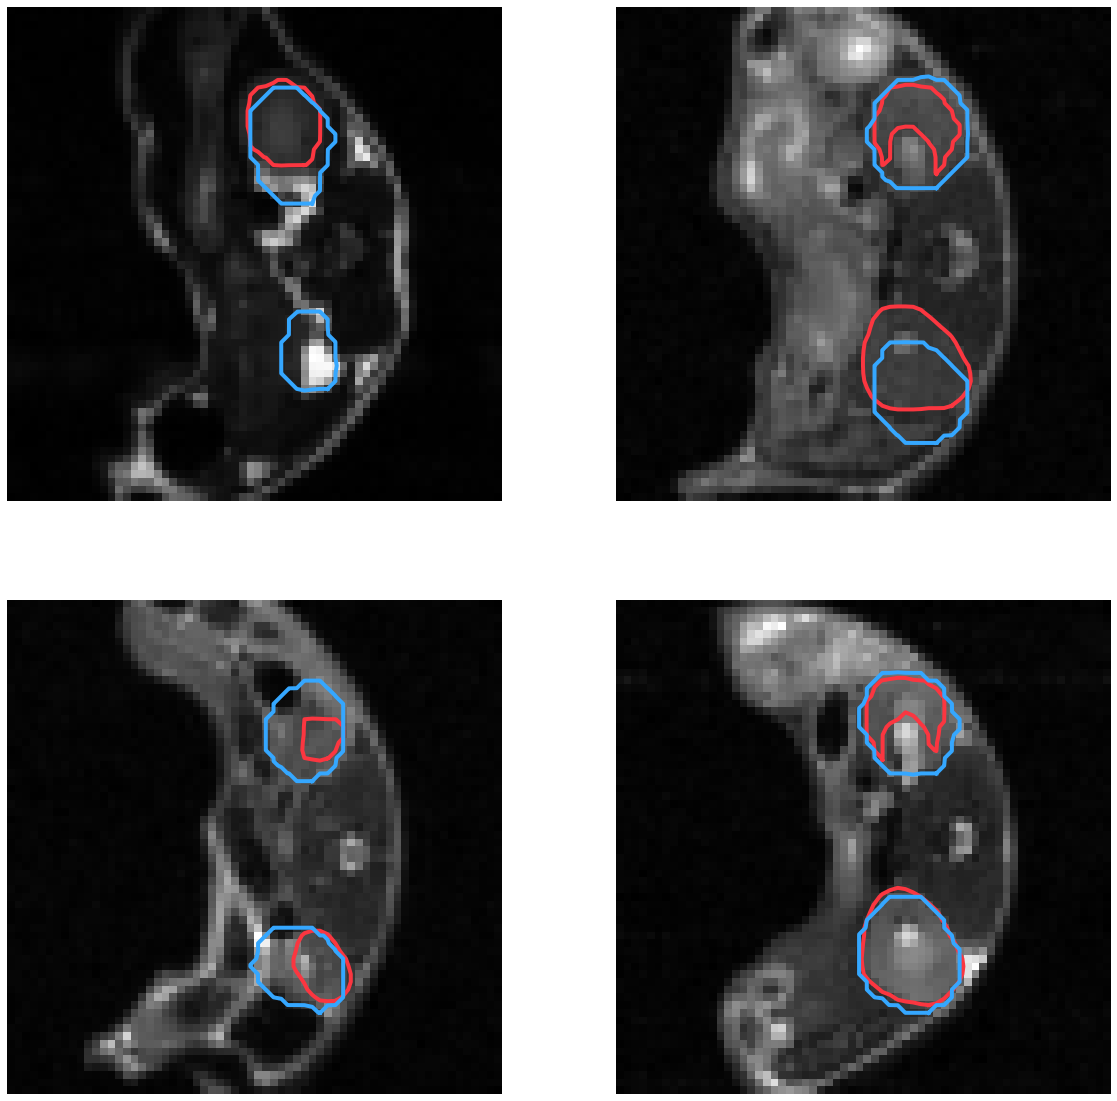

In [ ]:
visualise_data_and_prediction(x_test, y_test, y_pred_test)

## ------------ Your Turn -----------------

Below are suggestions for how this experiment could be modified.

  1. explore the keras_unet [github repository](https://github.com/karolzak/keras-unet). What parameters of the model could we change to further improve performance? How would you setup an experiment to find the best settings for these parameters?

  2. replicate the analysis of [Edwards et al. (2021)](https://reader.elsevier.com/reader/sd/pii/S0085253820309571?token=8C46B51948D5C9822571903C855A46B2A114B98D334C1F1FD510E5FB512D933E2D9D6C4DB40EF0B60E29118E61F6F0A6&originRegion=us-east-1&originCreation=20210823192742) comparing the automatic segmentations to the manual segmentations as closely as you can given the information you have access to.  Is there any bias in how the model segments in comparison to manual segmentations?
  